This notebook is used to develope routines for building the time-dependent scale factors and depths

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from salishsea_tools import viz_tools

%matplotlib inline

See NEMO vvl manul for details on this calculation.

$v^{i,j} = \sum_{k=0}^{jpk} e3t^{i,j,k,0} \sum_{n=k}^{jpk} e3t^{i,j,n,0} $
and 

$e3t^{i,j,k,t} = e3t^{i,j,k,0}\left(1 + \frac{\eta^{i,j,t}}{v^{i,j}}\sum_{n=k}^{jpk}e3t^{i,j,n,0}\right)$

Then 
* $e3w(k=0) = e3t(k=0)$
* $e3w(k>0) = \frac{1}{2} (e3t(k-1) + e3t(k))$
* $gdept(k=0) = \frac{e3t(k=0)}{2}$
* $gdept(k>0) = gdept(k-1) + e3w(k)$
* $gdepw(k=0) = 0$
* $gdepw(k>0) = gdepw(k-1) + e3t(k-1)

Strategy:
* Create function to calculate v
* Create an adjustment factor function that takes arugments ssh, e3t0 and v. The adjustment factor is equal to the bracketed terms in the equation.
* Create function that outputs time-dependet e3w, gdept, gdepw, e3t
* How do we figure out the u/v depths and scale factors?

# Loading

In [2]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]
# Sample file for testing calculations
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')

In [3]:
ssh = fT.variables['sossheig']
tmask = mesh_mask.variables['tmask'][:]
e3t_0 = mesh_mask.variables['e3t'][:]
gdept_0 = mesh_mask.variables['gdept'][:]
gdepw_0 = mesh_mask.variables['gdepw'][:]

# Functions

In [4]:
def calculate_v(e3t0, tmask):
    """Calculate the v correction factor for variable volume in NEMO.
    e3t0 and tmask must be the same shape.
    See NEMO vvl manual appendix A.1 for details. 
    
    :arg e3t0: initial vertical scale factors on T-grid. Dimensions: (depth, y, x).
    :type e3t0: numpy array
    
    :arg tmask: T-grid mask. Dimensions: (depth, y, x)
    :type tmask: numpy array

    :returns: the v correction factor with dimensions (y, x)
    
    """
    vn = 0
    for k in np.arange(e3t0.shape[0]):
        sum1 = 0
        for n in np.arange(k, e3t0.shape[0]):
            sum1 = sum1 + e3t0[n, ...]*tmask[n, ...]
        vn = vn +e3t0[k, :, :]*sum1*tmask[k, ...]
    return vn

Check that this worked

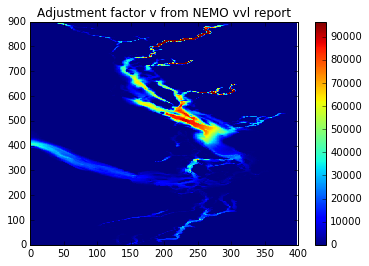

In [5]:
vn = calculate_v(e3t_0[0,...], tmask[0,...])
vn.shape
plt.pcolormesh(vn)
plt.colorbar()
plt.title('Adjustment factor v from NEMO vvl report')

In [6]:
def calculate_adjustment_factor(e3t0, tmask, v, ssh):
    """Calculate the adjustment factor for variable volume in NEMO.
    See NEMO vvl manual appendix A.1 for details. 
    
    :arg e3t0: initial vertical scale factors on T-grid. Dimensions: (depth, y, x).
    :type e3t0: numpy array
    
    :arg tmask: T-grid mask. Dimensions: (depth, y, x)
    :type tmask: numpy array
    
    :arg v: v correction factor. Dimension: (y, x)
    :type v: numpy array
    
    :arg ssh: the model sea surface height. Dimensions: (time, depth, y, x)
    :type ssh: numpy array

    :returns: the adjustement factor with dimensions (time, depth, y, x)
    """
    # Define shape of adj
    shape = list(e3t0.shape[:])
    shape.insert(0, ssh.shape[0])
    adj = np.zeros(shape)

    for k in np.arange(e3t0.shape[0]):
        sum1 = 0
        for n in np.arange(k,e3t0.shape[0]):
            sum1 = sum1 + e3t0[n, ...]*tmask[n, ...]
        adj[:, k, ...] = (1 + ssh/v*sum1)
    inds = np.where(np.isnan(adj))
    adj[inds] = 1  # Turn nans into ones
    
    return adj

In [7]:
adj = calculate_adjustment_factor(e3t_0[0,...], tmask[0,...], vn, ssh)
print(adj[0,:,400,300])

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in true_divide


[ 1.03261944  1.03122092  1.0298224   1.02842386  1.0270253   1.02562671
  1.02422804  1.02282921  1.02143009  1.0200304   1.01862959  1.0172266
  1.01581937  1.01440389  1.01297233  1.01150952  1.00998597  1.00834472
  1.0064764   1.00417393  1.00105537  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.        ]


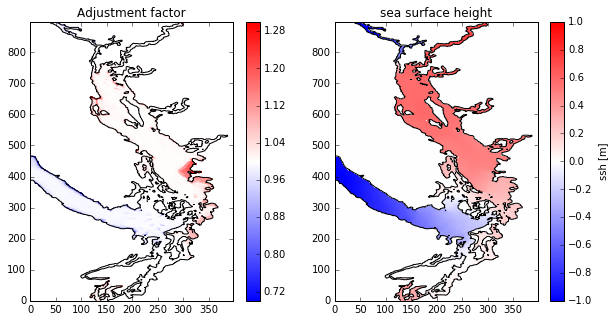

In [8]:
#Quick visualisation of adjustment factor at surface
t=0
d=0
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh=ax.pcolormesh(np.ma.array(adj[t,d,:,:],mask=1-tmask[0,d,:,:]),
                   vmin=.7,vmax=1.3,cmap='bwr')
plt.colorbar(mesh, ax=ax)
viz_tools.plot_coastline(ax,grid)
ax.set_title('Adjustment factor')
ax=axs[1]
mesh=plt.pcolormesh(ssh[t,:,:], vmin=-1,vmax=1,cmap='bwr')
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('ssh [m]')
viz_tools.plot_coastline(ax,grid)
ax.set_title('sea surface height')

In [9]:
# Check adjustment factor is >=1 where ssh >=0.
inds=np.where(ssh[:]>=0) 
(adj[inds[0],0,inds[1],inds[2]] >=1).all()

True

In [10]:
# Check adjustment factor is <1 where ssh <0.
inds=np.where(ssh[:]<0) 
(adj[inds[0],0,inds[1],inds[2]] <1).all()

True

In [11]:
# Check adj <1 is false when ssh >=0
inds=np.where(ssh[:]>=0) 
(adj[inds[0],0,inds[1],inds[2]] <1).all()

False

In [12]:
# Check adj >=1 is false when ssh <0
inds=np.where(ssh[:]<0) 
(adj[inds[0],0,inds[1],inds[2]] >=1).all()

False

In [13]:
def calculate_vertical_grids(e3t0, tmask, ssh):
    """    
    Calcuate the time dependent vertical grids and scale factors for variable volume in NEMO.
    See NEMO vvl manual appendix A.1 for details.
    
    :arg e3t0: initial vertical scale factors on T-grid. Dimensions: (depth, y, x).
    :type e3t0: numpy array
    
    :arg tmask: T-grid mask. Dimensions: (depth, y, x)
    :type tmask: numpy array
    
    :arg ssh: the model sea surface height. Dimensions: (time, depth, y, x)
    :type ssh: numpy array
    
    :returns: e3t_t, e3t_3, gdept_t, gdept_w
    The time dependent vertical scale factors on t and w grids and depths on t and w grids. 
    Dimensions: (time, depth, y, x)
    """
    
    # adjustment factors
    vn = calculate_v(e3t0, tmask)
    adj = calculate_adjustment_factor(e3t0, tmask, vn, ssh)
    # scale factors
    e3t_t = e3t0*adj
    e3w_t = np.copy(e3t_t)  # intiliaize for k=0
    e3w_t[:, 1:, ...] = 0.5*(e3t_t[:, 1:, ...] + e3t_t[:, 0:-1, ...])  # overwrite k>0   
    # depths
    gdept_t = 0.5*e3t_t  # initialize for k=0
    gdepw_t = np.zeros(gdept_t.shape)  # initialize for k=0
    for k in np.arange(1,gdept_t.shape[1]):
        gdept_t[:, k, ...] = gdept_t[:, k-1, ...] + e3w_t[:, k, ...]  # overwrite k>0
        gdepw_t[:, k, ...] = gdepw_t[:, k-1, ...] + e3t_t[:, k-1, ...]  # overwrite k>0
    
    return e3t_t, e3w_t, gdept_t, gdepw_t 

In [14]:
e3t_t, e3w_t, gdept_t, gdepw_t = calculate_vertical_grids(e3t_0[0,...], tmask[0,...], ssh)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in true_divide


Calculate total depth by summing vertical scale factors for both initial and time dependent scale factors to compare.

In [15]:
H_0 = np.sum(e3t_0*tmask, axis=1)
H_t = np.sum(e3t_t*tmask, axis=1)

In [16]:
diff_depth = H_t - H_0
diff_ssh = diff_depth-ssh

In [17]:
print('Mean difference with ssh: {} m'.format(diff_ssh.mean()))
print('Max difference with ssh: {} m'.format(diff_ssh.max()))
print('Min difference with ssh: {} m'.format(diff_ssh.min()))

Mean difference with ssh: -2.9087698903304887e-16 m
Max difference with ssh: 1.7053025658242404e-13 m
Min difference with ssh: -1.7053025658242404e-13 m


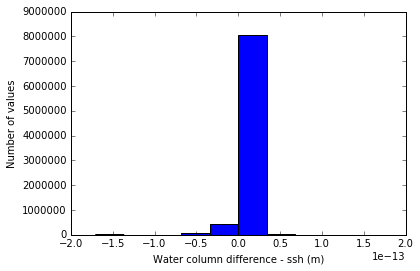

In [18]:
plt.hist(diff_ssh.flatten())
plt.xlabel('Water column difference - ssh (m)')
plt.ylabel('Number of values')

Ok, so the water column is expanding and compressing by exactly the ssh (to within reasonable error). That makes sense.

Next, check to make sure the bottom hasn't moved! That is, the w point that represents the bathymetry shouldn't be affected. 

Note that because the depth is like a pressure gdepw(k=0) = 0 because it is at the surface. So, compare gdepw_t[bottom] - ssh to gdepw_0[bottom].

In [19]:
mbathy = mesh_mask.variables['mbathy'][0,:,:]
bottom_0 = np.zeros(H_0[0,:,:].shape)
bottom_t = np.zeros(H_t.shape)
for i in np.arange(H_0[0,:,:].shape[1]):
    for j in np.arange(H_0[0,:,:].shape[0]):
        level = mbathy[j,i]
        bottom_0[j,i] = gdepw_0[0,level,j,i]
        bottom_t[:,j,i] = gdepw_t[:,level,j,i]

In [20]:
j=400
i=300
diff = bottom_t - bottom_0 - ssh

In [21]:
bottom_0[j,i]

23.375

In [22]:
bottom_t[:,j,i]

array([ 23.72414624,  23.3936103 ,  23.00307437,  22.6362254 ,
        22.41232693,  22.39079034,  22.58250838,  22.945014  ,
        23.4034994 ,  23.87082451,  24.23598778,  24.42061084,
        24.37138158,  24.11605256,  23.74233439,  23.31348083,
        22.92802986,  22.69490659,  22.67062753,  22.84080266,
        23.12815392,  23.46540339,  23.76746717,  23.92368096])

In [23]:
diff[:,j,i]

array([-0.05070109, -0.05070109, -0.05070109, -0.05070109, -0.05070109,
       -0.05070109, -0.05070109, -0.05070109, -0.05070109, -0.05070109,
       -0.05070109, -0.05070109, -0.05070109, -0.05070109, -0.05070109,
       -0.05070109, -0.05070109, -0.05070109, -0.05070109, -0.05070109,
       -0.05070109, -0.05070109, -0.05070109, -0.05070109])

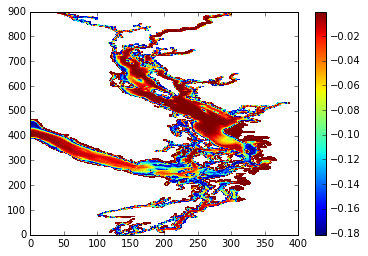

In [24]:
t=10
plt.pcolormesh(np.ma.array(diff[t], mask = 1-tmask[0,0,...]))
plt.colorbar()

In [25]:
print(np.max(diff))
print(np.min(diff))
print(np.mean(diff))

0.0
-0.181288886781
-0.0127123653176


I'm not sure why I'm getting a discrepancy here... There is up to an 18 cm difference. The deepest areas do no have very much discrepancy.  Question: Is this significant? 

It is also steady with time. It is interesting that discrepancy is always non-positive, meaning that the time dependent bottom is shallower.

# Next
Write this functions into a module grid_time.py